# Hybrid Classic-Quantum Systems - Third Assignment #

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

* You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
* If you want to modify the given functions, please, provide an explanation of why you had to;
* You can define new functions, as soon as they are well commented;
* You can import all libraries you want, as soon as you justify their utilization;
* You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
* This is a group assignment. The maximum number of people is 3;
* Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
* For any issue and doubt, please do not hesitate to use the forum or to write me an email.

# Preliminaries #

## Bin Packing Problem (BPP) ##
The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)

## Mathematical formulation ##
The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
    & {\min}\
    & &  \sum_{j=1}^{K} B_j \\
    & {\text{subject to}}
    & & g(x_{ij}) = \sum_{j=1}^{K} x_{ij} = 1 \qquad \forall i \\
    & & & h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} \le C*B_j \qquad \forall j
\end{align}

The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.

# Loading BPP instances #
First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:
* $w_i$ is the weight of item $i$;
* $C$ is the capacity of each bin;
* $B$ is the number of bins;
* $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:

In [38]:
import pickle

def read_list(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [39]:
# You might need to reupload bpp_instances
instances = read_list("bpp_instances")

# Transforming BPP into a QUBO #
QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding ##
Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters:
* *InequalityToEquality*: converts inequality constraints into equality constraints with additional slack variables.
* *IntegerToBinary* : converts integer variables into binary variables and corresponding coefficients.
* *LinearEqualityToPenalty* : convert equality constraints into additional terms of the object function.
* *QuadraticProgramToQubo* : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding ##

### Define penalties ###
To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
     \begin{align*}
        g(x_{ij}) = \sum_{j=1}^{K} x_{ij} - 1 = 0 \qquad \forall i \\
        h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
    \end{align*}
    Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
            \lambda g(x_{ij}) & \text{if $g(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
            \beta h(x_{ij}) & \text{if $h(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    
In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model ###
To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
    \mathcal{F} = \sum_{j=1}^{K} B_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions ###
* https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
* https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

## YOUR TASK ##
* Apply slack + quadratic penalty
* Apply penalty-based encoding using three functions

In [40]:
install = False
if (install):
  !pip install qiskit
  !pip install qiskit_optimization
  !pip install qiskit-optimization[cplex]
  !pip install docplex
  !pip install cplex
  !pip install qiskit-aer
  !pip install seaborn

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

In [42]:
print(instances)

[[[55, 40, 25, 50], 100, 3, 4], [[80, 20, 55, 15], 120, 3, 4], [[70, 35, 15, 70], 100, 3, 4], [[10, 55, 65, 35], 120, 3, 4], [[35, 40, 45, 50], 100, 3, 4], [[95, 50, 45, 25], 120, 3, 4], [[60, 25, 75, 25], 100, 3, 4], [[55, 10, 60], 120, 2, 3], [[55, 60, 35], 100, 2, 3], [[40, 95, 60], 120, 2, 3], [[55, 50, 5], 100, 2, 3], [[100, 30, 35], 120, 2, 3], [[50, 50, 30], 100, 2, 3], [[30, 60, 75], 120, 2, 3], [[25, 20, 15, 20, 5], 100, 1, 5], [[10, 40, 40, 20, 5], 120, 1, 5], [[10, 20, 25, 15, 25], 100, 1, 5], [[5, 10, 15, 25, 35], 120, 1, 5], [[5, 40, 10, 5, 35], 100, 1, 5], [[40, 35, 10, 15, 20], 120, 1, 5], [[10, 15, 25, 10, 15], 100, 1, 5]]


In [43]:
"""
  Defines the classical model for BPP.

  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins

  returns: classical model for BPP, according to the input parameters
"""
def get_classical_model(n, m, w, C):

  mdl = Model("BPP")

  B = mdl.binary_var_list(m, name='B')
  x = mdl.binary_var_matrix(m, n, name='x')
  mdl.minimize(mdl.sum(B[j] for j in range(m)))

  # adding constraints
  for i in range(n):
      mdl.add_constraint(mdl.sum(x[j, i] for j in range(m)) == 1)

  for j in range(m):
      mdl.add_constraint(mdl.sum(w[i] * x[j, i] for i in range(n)) <= C * B[j])

  return mdl


In [44]:
# Load quadratic program from docplex model
mdl = get_classical_model(instances[0][3], instances[0][2], instances[0][0], instances[0][1])
qp = from_docplex_mp(mdl)
print(type(qp))
print(qp.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>
Problem name: BPP

Minimize
  B_0 + B_1 + B_2

Subject to
  Linear constraints (7)
    x_0_0 + x_1_0 + x_2_0 == 1  'c0'
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    -100*B_0 + 55*x_0_0 + 40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 0  'c4'
    -100*B_1 + 55*x_1_0 + 40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 0  'c5'
    -100*B_2 + 55*x_2_0 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (15)
    B_0 B_1 B_2 x_0_0 x_0_1 x_0_2 x_0_3 x_1_0 x_1_1 x_1_2 x_1_3 x_2_0 x_2_1
    x_2_2 x_2_3



In [45]:
"""
  Simplifies the quadratic problem by reducing variables related to reasonable assumptions.

  qp: quadratic problem with BPP
  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
"""
def simplify_quadratic_problem(qp, m, w, C):
  min_bins = int(np.ceil(np.sum(w)/C))

  # The minimum number of bins is the one necessary to cover the sum of the items' weight
  # That means the first num_bins bins will be used
  for i in range(min_bins):
    qp = qp.substitute_variables({f"B_{i}": 1})

  # We can assume the first item will be allocated to the first bin
  # This is true because all bins have the same capacity and the problem is assumed feasible
  qp = qp.substitute_variables({"x_0_0": 1})

  # The first item is not in any other bin
  for i in range(1, m):
    qp = qp.substitute_variables({f"x_{i}_0": 0})

  return qp

In [46]:
qp = simplify_quadratic_problem(qp, instances[0][2], instances[0][0], instances[0][1])
print(qp.prettyprint())

Problem name: BPP

Minimize
  B_2 + 2

Subject to
  Linear constraints (6)
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 45  'c4'
    40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 100  'c5'
    -100*B_2 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (10)
    B_2 x_0_1 x_0_2 x_0_3 x_1_1 x_1_2 x_1_3 x_2_1 x_2_2 x_2_3



In [47]:
"""
  Applies penalty-based encoding to the quadratic problem.

  qp: instace of a quadratic problem

  returns: qubo version of a quadratic problem
"""
def apply_penalty_encoding(qp):
  ineq_to_eq = InequalityToEquality()
  qp_eq = ineq_to_eq.convert(qp)

  int_to_bin = IntegerToBinary()
  qp_eq_bin = int_to_bin.convert(qp_eq)

  lin_eq_to_penalty = LinearEqualityToPenalty()
  qubo = lin_eq_to_penalty.convert(qp_eq_bin)

  return qubo

qubo_test = apply_penalty_encoding(qp)
print(f"The number of variables is {qubo_test.get_num_vars()}")
print(qubo_test.prettyprint())


The number of variables is 30
Problem name: BPP

Minimize
  20000*B_2^2 - 400*B_2*c6@int_slack@0 - 800*B_2*c6@int_slack@1
  - 1600*B_2*c6@int_slack@2 - 3200*B_2*c6@int_slack@3 - 6400*B_2*c6@int_slack@4
  - 12800*B_2*c6@int_slack@5 - 14800*B_2*c6@int_slack@6 - 16000*B_2*x_2_1
  - 10000*B_2*x_2_2 - 20000*B_2*x_2_3 + 2*c4@int_slack@0^2
  + 8*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@0*c4@int_slack@2
  + 32*c4@int_slack@0*c4@int_slack@3 + 64*c4@int_slack@0*c4@int_slack@4
  + 56*c4@int_slack@0*c4@int_slack@5 + 8*c4@int_slack@1^2
  + 32*c4@int_slack@1*c4@int_slack@2 + 64*c4@int_slack@1*c4@int_slack@3
  + 128*c4@int_slack@1*c4@int_slack@4 + 112*c4@int_slack@1*c4@int_slack@5
  + 32*c4@int_slack@2^2 + 128*c4@int_slack@2*c4@int_slack@3
  + 256*c4@int_slack@2*c4@int_slack@4 + 224*c4@int_slack@2*c4@int_slack@5
  + 128*c4@int_slack@3^2 + 512*c4@int_slack@3*c4@int_slack@4
  + 448*c4@int_slack@3*c4@int_slack@5 + 512*c4@int_slack@4^2
  + 896*c4@int_slack@4*c4@int_slack@5 + 392*c4@int_slack@5^2
 

In [48]:
"""
  Defines the QUBO model for BPP.

  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
  simplify: If True, simplifies the problem by reducing number of variables

  returns: QUBO model for BPP (quadratic problem), according to the input parameters
"""
def get_qubo(n, m, w, C, simplify = True):
    mdl = get_classical_model(n, m, w, C)
    qp = from_docplex_mp(mdl)
    if simplify:
      qp = simplify_quadratic_problem(qp, m, w, C)
    qubo = apply_penalty_encoding(qp)
    return qubo

# Encoding QUBO into ISING Hamiltonian #
The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to_ising}
    \begin{split}
    x_i = \frac{1-z_i}{2}\\
    z_i*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
    z_i = \sigma_Z^i
    \end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix
$\begin{pmatrix}
  1 & 0\\
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
    H_{bpp}= \sum_{j=1}^{K} \sigma_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.

## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian ##

In [49]:
"""
  Encodes a quadratic problem instance representing a QUBO as a Ising Hamiltonian.

  qubo: quadratic problem representing a QUBO

  returns: Operator instance representing the Ising Hamiltonian
"""
def encode_qubo_as_ising(qubo):
  operator, _ = qubo.to_ising()
  return operator

# This step is not needed for solving the problem, since the optimizers
# convert the QUBO into a Ising Hamiltonian under the hood

In [50]:
operator = encode_qubo_as_ising(qubo_test)
print(operator)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIZ',

# Solving BPP instances #
Solve each problem instances using different methods:
## CPLEX optimizer ##
Classic optimizer, to be used as baseline with all the others.

In [51]:
"""
  Plots the result of an optimizer.

  result: result of the optimizer
  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
  simplify: informs whether the problem was simplified or not
"""
def plot_result(result, n, m, w, C, simplify = True):
  results = result.x

  if simplify:
    # Re-add the simplification variables
    min_bins = int(np.ceil(np.sum(w)/C))
    for _ in range(min_bins):
      results = np.insert(results, 0, 0) # Unused bins
    results = np.insert(results, m, 1) # First item always at first bin
    for bin in range(1, m): # First item is only in first bin
      results = np.insert(results, m + bin * n, 0)

  plt.figure()

  items = results[m:m + m * n].reshape(m, n) * w

  indices = np.arange(m)
  plt.bar(indices, items[:, 0], label=f"Item {0}")

  item_nums = items[:, 0]
  for j in range(1, n):
      plt.bar(indices, items[:, j], bottom=item_nums, label=f"Item {j}")
      item_nums += items[:, j]

  plt.hlines(C, -0.5, m - 0.5, linestyle="--", color="r", label="Capacity")
  plt.xticks(indices)
  plt.xlabel("Bin")
  plt.ylabel("Weight")
  plt.legend()
  plt.show()

In [52]:
from qiskit_optimization.algorithms import CplexOptimizer
import time

In [53]:
"""
  Solves the classical version of BPP and plots the result.

  qp: quadratic problem representing BPP
"""
def solve_classical(instance):
  
  n = instance[3]
  m = instance[2]
  w = instance[0]
  C = instance[1]

  mdl = get_classical_model(n, m, w, C)
  qp = from_docplex_mp(mdl)
  qp = simplify_quadratic_problem(qp, m, w, C)

  optimizer = CplexOptimizer()

  start_time = time.perf_counter()
  result = optimizer.solve(qp)
  end_time = time.perf_counter()

  print("Elapsed time:", end_time - start_time)
  
  print(result)
  plot_result(result, n, m, w, C)

  return result.fval, end_time - start_time, result.status.name == 'SUCCESS'

Elapsed time: 0.019211200007703155
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


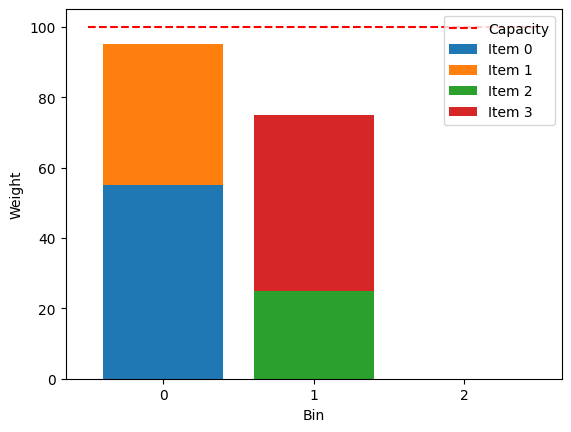

(2.0, 0.019211200007703155, False)

In [54]:
solve_classical(instances[0])

## QAOA solution and Warm start QAOA ##

The implementation of QAOA and warm start QAOA were done in the same method

In [55]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.algorithms.optimizers import SPSA
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
from qiskit.primitives import Sampler
from qiskit.primitives import BackendSampler
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePrague
import time
import pandas as pd

In [56]:
"""
  Solves the QUBO version of BPP and plots the result.

  instance: instance of BPP
  optimizer: optimizer to be used
  backend: backend to be used
  shots: number of shots to be used
  p: p value for QAOAAnsatz
  warm_start: informs whether the warm start technique should be used
"""
def solve_qaoa(instance, optimizer, backend, shots, p, warm_start = False, use_perfect_simulator = False):
  
  n = instance[3]
  m = instance[2]
  w = instance[0]
  C = instance[1]

  qubo = get_qubo(n, m, w, C)

  # Because of qiskit limitations, we can either select the backend or the number of shots
  if (not use_perfect_simulator) and shots is None:
    sampler = BackendSampler(backend=backend)
  elif shots is not None: # default backend is used
    sampler = Sampler(options={'shots': shots})
  else:
    sampler = Sampler()

  qaoa = QAOA(sampler, optimizer, reps=p)

  if warm_start:
    optimizer = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa)
  else:
    optimizer = MinimumEigenOptimizer(qaoa)

  if warm_start:
    optimizer = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa)
  else:
    optimizer = MinimumEigenOptimizer(qaoa)

  start_time = time.perf_counter()
  result = optimizer.solve(qubo)
  end_time = time.perf_counter()

  print("Elapsed time:", end_time - start_time)

  print(result)
  plot_result(result, n, m, w, C)

  return result.fval, end_time - start_time, result.status.name == 'SUCCESS'

In [57]:
# check if any instance exceeds 32 variables, the maximum for QAOA
exceeds = False
for instance in instances:
    qubo = get_qubo(instance[3], instance[2], instance[0], instance[1])
    if qubo.get_num_vars() > 32:
        print(
            "[WARNING] Instance",
            instance,
            "exceeded 32 variables! The models might fail",
        )
        exceeds = True
if not exceeds:
    print("No instance exceeds 32 variables. Everything should work as expected")

No instance exceeds 32 variables. Everything should work as expected


In [58]:
run_quantum = False

if run_quantum:
    solve_qaoa(instances[0], COBYLA(), None, None, 2, use_perfect_simulator=True)
    solve_qaoa(instances[0], COBYLA(), None, None, 2, warm_start=True, use_perfect_simulator=True)

# Evaluation #

Evaluate quantum solutions in comparison with classic solution using the following metrics:
* Running time;
* Mean square error between quantum optimum and classic optimum;
* Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:
* Noiseless simulator (Aer)
* Noisy simulator (choose a noise model)
* BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:
* QAOAAnsatz with $p=[1,5]$
* Optimizers: COBYLA, NelderMead, SLSQP
* Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
* Optimizers' iteration: {250, 500, 750, 1000}

In [59]:
"""
    Solves the given instance with the chosen parameters with quantum algorithms, both with and without warm start.

    instance: instance to be solved
    backend_name: name of the backend to be used
    backend: backend to be used
    optimizer_name: name of the optimizer to be used
    optimizer: optimizer to be used
    optimizer_iteration: number of iterations of the optimizer
    shots: number of shots to be used
    p: p value of QAOAAnsatz
    dfs: dictionary of dataframes to store the results
"""
def solve_and_get_metrics(instance, backend_name, backend, optimizer_name, optimizer, optimizer_iteration, shots, p):
    # qasm and aer have a low qubit number, so we can use QAOA's default perfect simulator
    use_perfect_simulator = backend_name == 'qasm_simulator' or backend_name == 'aer_simulator'

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, 
                                      p=p, use_perfect_simulator=use_perfect_simulator)
    
    result_qaoa = {'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                   'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                   'optimizer_iteration': optimizer_iteration, 'p': p}

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, 
                                      p=p, warm_start=True, use_perfect_simulator=use_perfect_simulator)
    
    result_warm_start_qaoa = {'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                              'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                              'optimizer_iteration': optimizer_iteration, 'p': p}

    return result_qaoa, result_warm_start_qaoa

First definitions

In [86]:
import os

In [60]:
columns_quantum = ['instance', 'time', 'optimum', 'found', 'optimizer', 'backend', 'shots', 'optimizer_iteration', 'p']
columns_classical = ['instance', 'time', 'optimum', 'found']

#backends = {'aer_simulator': Aer.get_backend("qasm_simulator"), 'fake_prague': FakePrague()}
backends = {'aer_simulator': Aer.get_backend("qasm_simulator")}
solvers = ['cplex', 'qaoa', 'warm_start_qaoa']

p_list = [1, 2]
optimizers = {'cobyla': COBYLA(), 'nelder_mead': NELDER_MEAD(), 'spsa': SPSA()}
shots_list = [200, 400, 600, 800, 1000]
optimizer_iterations = [250, 500, 750, 1000]

DEFAULT_P = 1
DEFAULT_OPTIMIZER = 'cobyla'
DEFAULT_SHOTS = None
DEFAULT_OPTIMIZER_ITERATION = 1000

instances.reverse() # We want to start with the smallest instances

dataframes = {}
dataframes['cplex'] = pd.DataFrame(columns=columns_classical)
dataframes['qaoa'] = pd.DataFrame(columns=columns_quantum)
dataframes['warm_start_qaoa'] = pd.DataFrame(columns=columns_quantum)

# create folder if it does not exist
if not os.path.exists('results'):
    os.makedirs('results')

Elapsed time: 0.013389399973675609
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


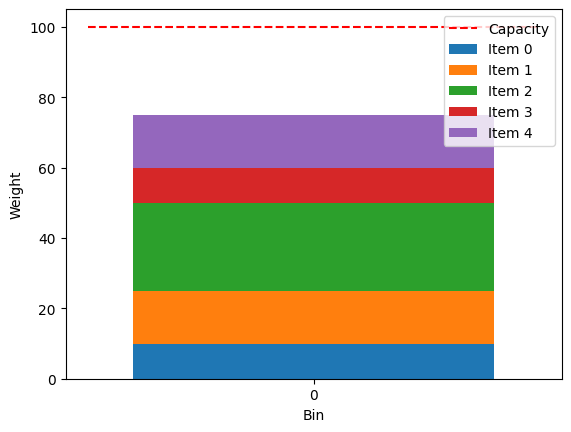

Elapsed time: 0.0132797000114806
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


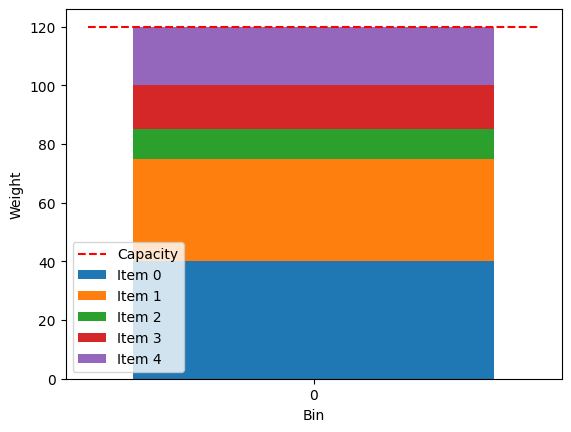

Elapsed time: 0.012794399983249605
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


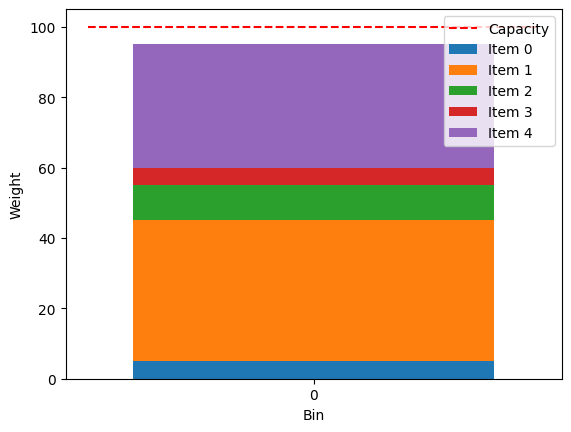

Elapsed time: 0.012379100022371858
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


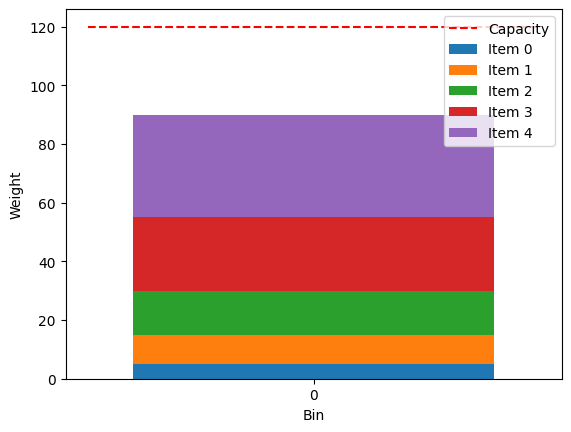

Elapsed time: 0.014129099959973246
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


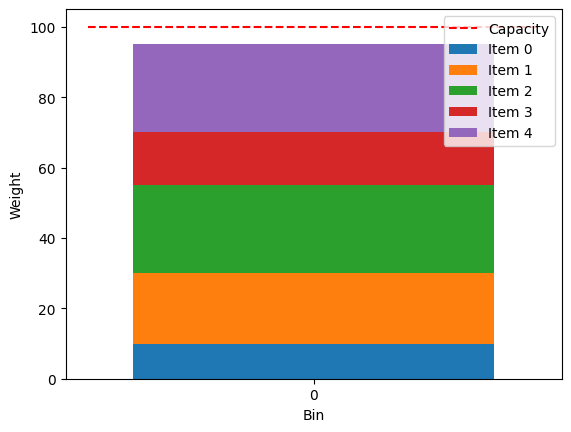

Elapsed time: 0.011585800035391003
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


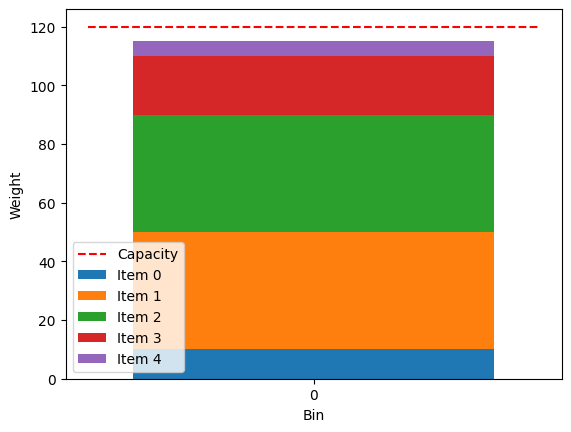

Elapsed time: 0.01222930004587397
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


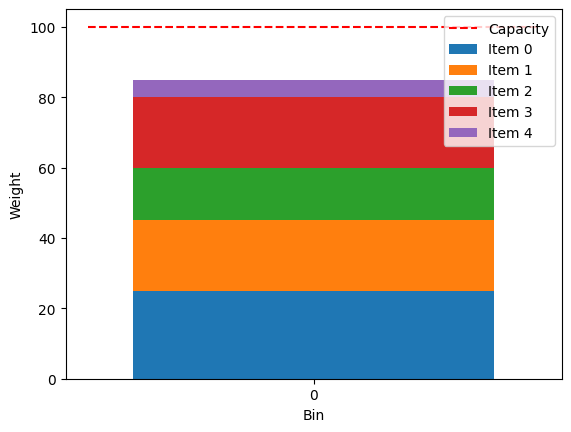

Elapsed time: 0.010097499995026737
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


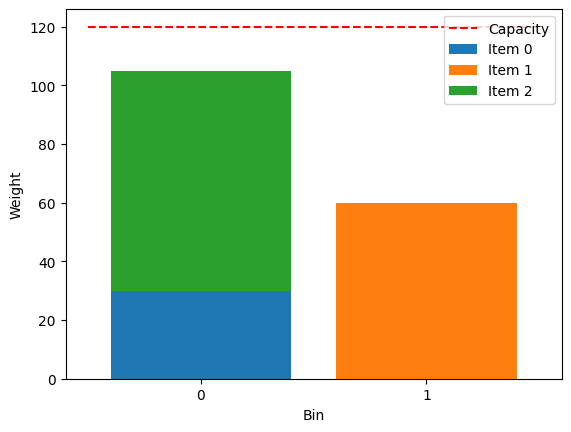

Elapsed time: 0.011825599998701364
fval=2.0, x_0_1=1.0, x_0_2=0.0, x_1_1=0.0, x_1_2=1.0, status=SUCCESS


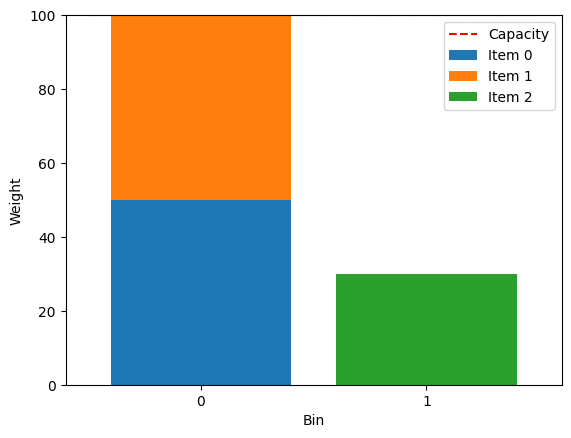

Elapsed time: 0.01180390000808984
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


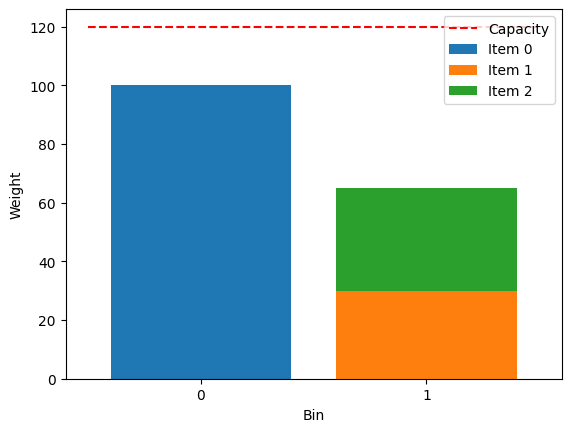

Elapsed time: 0.011893499991856515
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


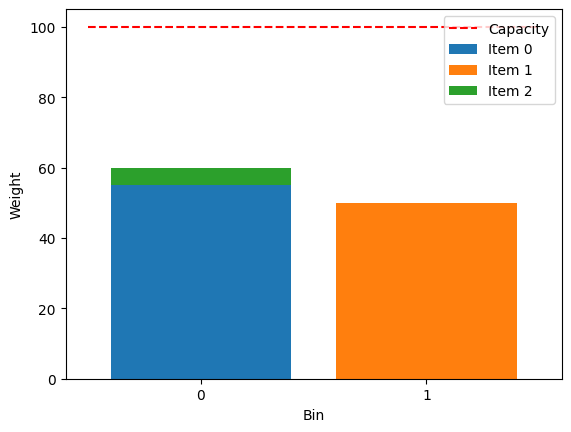

Elapsed time: 0.012360399996396154
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


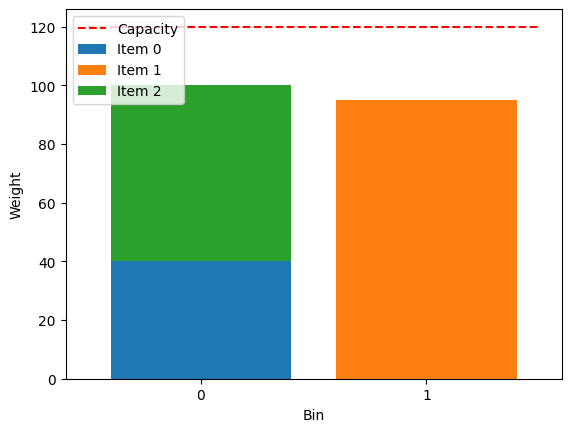

Elapsed time: 0.010872800019569695
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


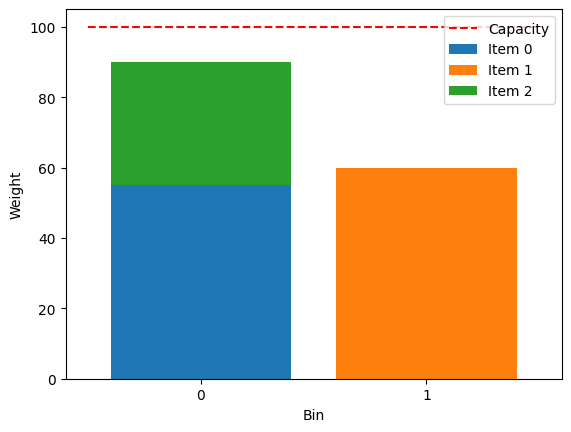

Elapsed time: 0.011914300033822656
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


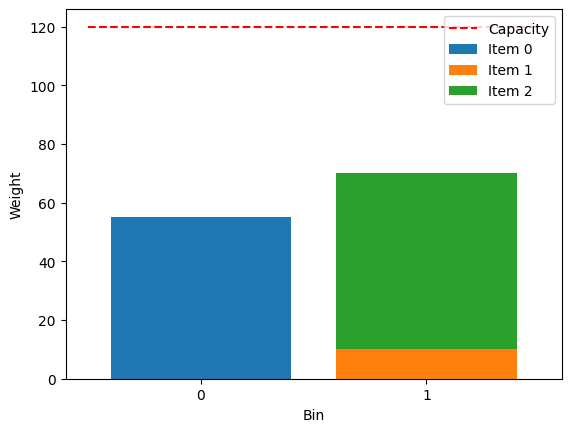

Elapsed time: 0.016120399988722056
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


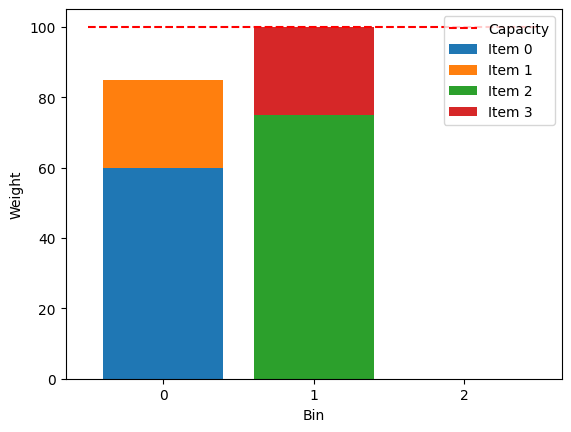

Elapsed time: 0.012219899974297732
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_1=1.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


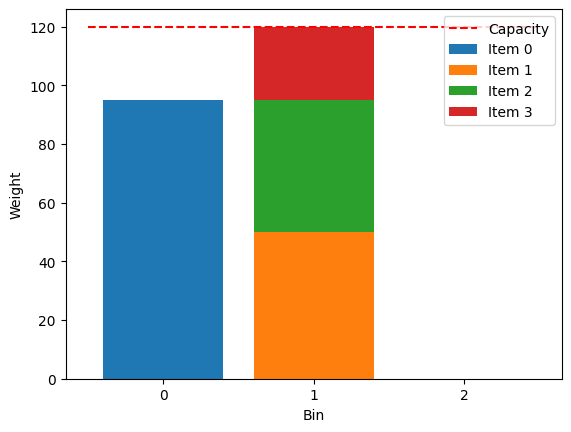

Elapsed time: 0.014166100008878857
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


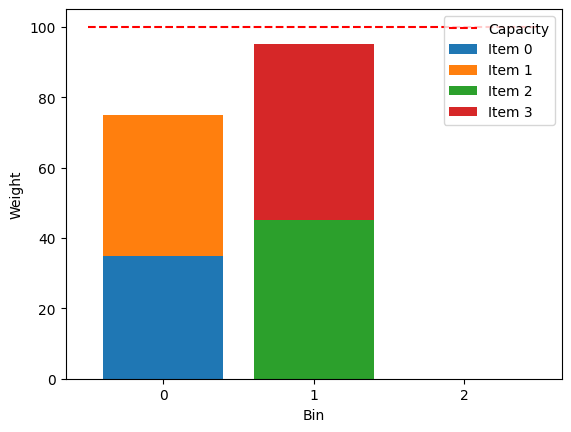

Elapsed time: 0.01696859998628497
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


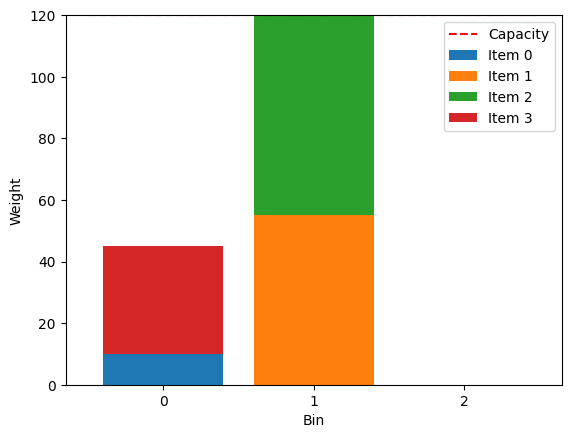

Elapsed time: 0.013962000026367605
fval=3.0, B_2=1.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


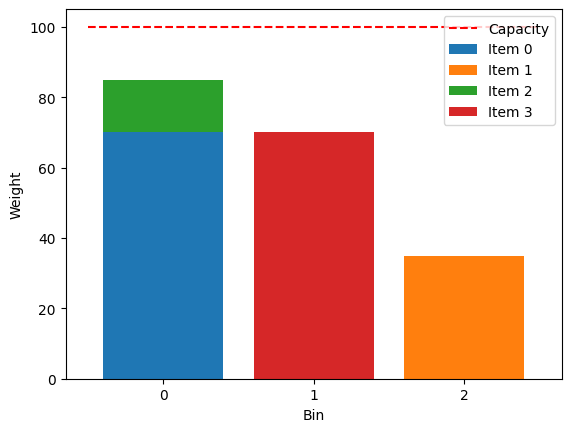

Elapsed time: 0.01505609997548163
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


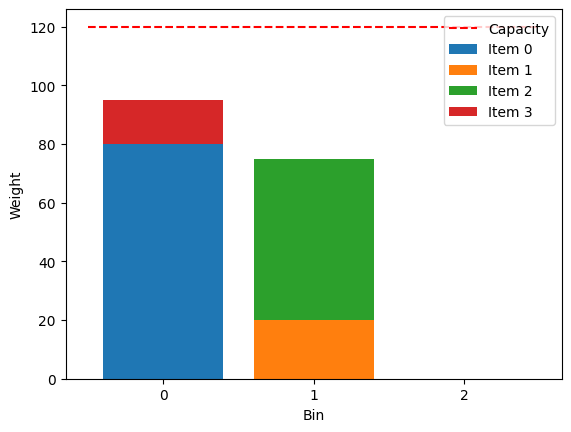

Elapsed time: 0.01789210003335029
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


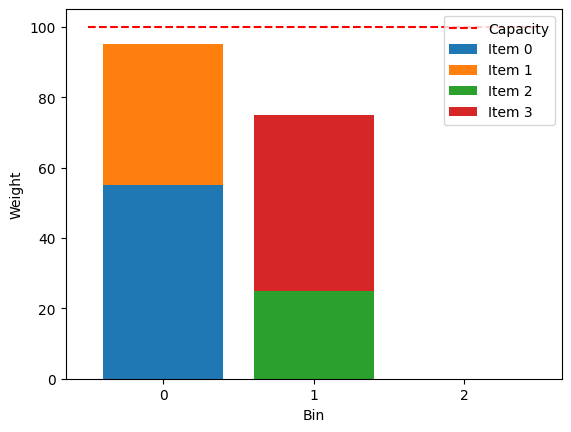

In [61]:
run_classical = True
if run_classical:
    for instance in instances:
        optimum, elapsed_time, found = solve_classical(instance)
        new_row = {'instance': instances.index(instance), 'time': elapsed_time, 'optimum': optimum, 'found': found}
        dataframes['cplex'] = pd.concat([dataframes['cplex'], pd.DataFrame([new_row])], ignore_index=True)
        dataframes['cplex'].to_csv('cplex.csv', index=False)

Classical runs

Quantum runs

In [62]:
def compute_metrics(instance, backend_name, backend, optimizer_name, optimizer, 
                    optimizer_iteration, shots, p, data_qaoa, data_warm_start_qaoa):
    print(f"Running instance {instances.index(instance)} with {backend_name}, {optimizer_name}, {shots} shots, {p} p, {optimizer_iteration} iterations")
    qaoa, ws_qaoa = solve_and_get_metrics(instance, backend_name, backend, optimizer_name, 
                                          optimizer, optimizer_iteration, shots, p)
    data_qaoa.append(qaoa)
    df = pd.DataFrame(data_qaoa)
    df.to_csv('qaoa.csv', index=False)
    data_warm_start_qaoa.append(ws_qaoa)
    df = pd.DataFrame(data_warm_start_qaoa)
    df.to_csv('warm_start_qaoa.csv', index=False)

In [63]:
# Be aware that running the quantum algorithms will take a long time and consume a lot of resources

run_quantum = False

if run_quantum:
    data_qaoa = []
    data_warm_start_qaoa = []
    for instance in instances:
        print(instance)
        try:
            for backend_name, backend in backends.items():
                for p in p_list:
                    compute_metrics(instance, backend_name, backend, 'cobyla', optimizers['cobyla'], 
                                    DEFAULT_OPTIMIZER_ITERATION, DEFAULT_SHOTS, p, data_qaoa, data_warm_start_qaoa)
                for optimizer_name, optimizer in optimizers.items():
                    compute_metrics(instance, backend_name, backend, optimizer_name, optimizer, 
                                    DEFAULT_OPTIMIZER_ITERATION, DEFAULT_SHOTS, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
                for optimizer_iteration in optimizer_iterations:
                    cobyla_optimizer = COBYLA(maxiter=optimizer_iteration)
                    compute_metrics(instance, backend_name, backend, DEFAULT_OPTIMIZER, cobyla_optimizer, optimizer_iteration, 
                                    DEFAULT_SHOTS, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
            for shots in shots_list:
                compute_metrics(instance, "aer_simulator", None, DEFAULT_OPTIMIZER, optimizers['cobyla'], 
                                DEFAULT_OPTIMIZER_ITERATION, shots, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
        except Exception as e:
            print(f"Error for instance {instance}")
            print(e)

### Metrics

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [76]:
# load dataframes from csv
csv_data = {}
csv_data['cplex'] = pd.read_csv('data/kaggle_cplex.csv')
csv_data['qaoa'] = pd.read_csv('data/kaggle_qaoa.csv')
csv_data['warm_start_qaoa'] = pd.read_csv('data/kaggle_warm_start_qaoa.csv')

In [77]:
"""
    Computes the mean squared error between the quantum and classical results.
    The parameters are used to filter the results.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
"""
def compute_mse(optimizer_name, shots, optimizer_iteration, p, dfs, warm_start = False):
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    if shots is None:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]
    else:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["shots"] == shots)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]
    classical_results = dfs['cplex']
    # get length of dataframe
    n = len(qaoa_results)
    mse = np.mean((qaoa_results['optimum'] - classical_results['optimum'])**2)
    return mse

In [78]:
"""
    Computer the number of times the quantum algorithm found the optimum, by comparing to the classical results.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
"""
def compute_optimum_quantity(optimizer_name, shots, optimizer_iteration, p, dfs, warm_start = False):
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    if shots is None:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]
    else:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["shots"] == shots)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]
    classical_results = dfs["cplex"]

    # Merge the two dataframes on the 'instance' column
    merged_results = pd.merge(
        qaoa_results, classical_results, on="instance", suffixes=("_qaoa", "_cplex")
    )

    # Compare the 'optimum' column from both dataframes
    optimum_quantity = np.sum(
        merged_results["optimum_qaoa"] == merged_results["optimum_cplex"]
    )
    return optimum_quantity

In [79]:
def compute_execution_metrics(optimizer_name, shots, optimizer_iteration, p, dfs, warm_start = False):
    
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    if shots is None:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]
    else:
        qaoa_results = dfs[df_name][
            (dfs[df_name]["optimizer"] == optimizer_name)
            & (dfs[df_name]["shots"] == shots)
            & (dfs[df_name]["optimizer_iteration"] == optimizer_iteration)
            & (dfs[df_name]["p"] == p)
        ]

    mean_time = np.mean(qaoa_results["time"])
    min_time = np.min(qaoa_results["time"])
    max_time = np.max(qaoa_results["time"])

    return mean_time, min_time, max_time

In [80]:
def compute_mse_optimum_time(optimizer_name, shots, optimizer_iteration, p, dfs):
    
    mse = compute_mse(optimizer_name, shots, optimizer_iteration, p, dfs)
    mse_warmup = compute_mse(optimizer_name, shots, optimizer_iteration, p, dfs, warm_start=True)

    optimum_quantity = compute_optimum_quantity(optimizer_name, shots, optimizer_iteration, p, dfs)
    optimum_quantity_warmup = compute_optimum_quantity(optimizer_name, shots, optimizer_iteration, p, dfs, warm_start=True)

    mean_time, min_time, max_time = compute_execution_metrics(
        optimizer_name, shots, optimizer_iteration, p, dfs
    )
    mean_time_warmup, min_time_warmup, max_time_warmup = compute_execution_metrics(
        optimizer_name, shots, optimizer_iteration, p, dfs, warm_start=True
    )

    results = {"optimizer": optimizer_name,
               "shots": shots,
               "optimizer_iteration": optimizer_iteration,
               "p": p,
               "mse": mse,
               "mse_warmup": mse_warmup,
               "optimum_quantity": optimum_quantity,
               "optimum_quantity_warmup": optimum_quantity_warmup,
               "mean_time": mean_time,
               "mean_time_warmup": mean_time_warmup,
               "min_time": min_time,
               "min_time_warmup": min_time_warmup,
               "max_time": max_time,
               "max_time_warmup": max_time_warmup}     
    
    return results

Metrics computation

In [81]:
classic_mean_time = np.mean(csv_data["cplex"]["time"])
classic_min_time = np.min(csv_data["cplex"]["time"])
classic_max_time = np.max(csv_data["cplex"]["time"])

# Compute mean square error for all combinations
results = []

for optimizer_name in optimizers.keys():
    results.append(compute_mse_optimum_time(optimizer_name, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, csv_data))

for shots in shots_list:
    results.append(compute_mse_optimum_time(DEFAULT_OPTIMIZER, shots, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, csv_data))

for optimizer_iteration in optimizer_iterations:
    results.append(compute_mse_optimum_time(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, optimizer_iteration, DEFAULT_P, csv_data))

for p in p_list:
    results.append(compute_mse_optimum_time(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, p, csv_data))

# Print evaluation results

print("Mean time for classical:", classic_mean_time)
print("Min time for classical:", classic_min_time)
print("Max time for classical:", classic_max_time, "\n")

print("\nEvaluations for QAOA:\n")

for result in results:
    print(
        f"Optimizer: {result['optimizer']}, Shots: {result['shots']}, Optimizer Iteration: " +
        f"{result['optimizer_iteration']}, p: {result['p']}, MSE: {result['mse']}, No. of optimum solutions: " +
        f"{result['optimum_quantity']}, Mean time: {result['mean_time']}, Min time: " +
        f"{result['min_time']}, Max time: {result['max_time']}"
    )

print("\nEvaluations for warm start QAOA:\n")

for result in results:
    print(
        f"Optimizer: {result['optimizer']}, Shots: {result['shots']}, Optimizer Iteration: " +
        f"{result['optimizer_iteration']}, p: {result['p']}, MSE: {result['mse_warmup']}, No. of optimum solutions: " +
        f"{result['optimum_quantity_warmup']}, Mean time: {result['mean_time_warmup']}, Min time: " +
        f"{result['min_time_warmup']}, Max time: {result['max_time_warmup']}"
    )

df = pd.DataFrame(results)

Mean time for classical: 0.0190079365712292
Min time for classical: 0.0153434359999664
Max time for classical: 0.0238176319999183 


Evaluations for QAOA:

Optimizer: cobyla, Shots: None, Optimizer Iteration: 1000, p: 1, MSE: 0.6, No. of optimum solutions: 51, Mean time: 117.36546137856624, Min time: 3.238818055000138, Max time: 1115.348038103
Optimizer: nelder_mead, Shots: None, Optimizer Iteration: 1000, p: 1, MSE: 0.5, No. of optimum solutions: 10, Mean time: 299.3011541176, Min time: 14.982894424000053, Max time: 1328.875271808
Optimizer: spsa, Shots: None, Optimizer Iteration: 1000, p: 1, MSE: 2.0, No. of optimum solutions: 10, Mean time: 610.3234998552, Min time: 41.02393518100007, Max time: 2644.510824106
Optimizer: cobyla, Shots: 200, Optimizer Iteration: 1000, p: 1, MSE: 1.0, No. of optimum solutions: 2, Mean time: 39.77267096349999, Min time: 3.238818055000138, Max time: 165.05760347000069
Optimizer: cobyla, Shots: 400, Optimizer Iteration: 1000, p: 1, MSE: 1.0, No. of optimu

In [82]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [83]:
def specific_plot(df, x):
    palette = "Blues_d"
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(x=x, y="mse", data=df, palette=palette, ci=None)
    plt.title("MSE")
    plt.subplot(1, 3, 2)
    sns.barplot(x=x, y="optimum_quantity", data=df, palette=palette, ci=None)
    plt.title("Number of optimum solutions")
    plt.subplot(1, 3, 3)
    sns.barplot(x=x, y="mean_time", data=df, palette=palette, ci=None)
    plt.title("Mean time")

    plt.savefig(f"plots/{x}.png")
    plt.show()

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(x=x, y="mse_warmup", data=df, palette=palette, ci=None)
    plt.title("MSE")
    plt.subplot(1, 3, 2)
    sns.barplot(x=x, y="optimum_quantity_warmup", data=df, palette=palette, ci=None)
    plt.title("Number of optimum solutions")
    plt.subplot(1, 3, 3)
    sns.barplot(x=x, y="mean_time_warmup", data=df, palette=palette, ci=None)
    plt.title("Mean time")

    plt.savefig(f"plots/{x}_warmup.png")
    plt.show()

In [84]:
def plot_results(df):
    if not os.path.exists('plots'):
        os.makedirs('plots')
    features = ['optimizer', 'shots', 'optimizer_iteration', 'p']
    for feature in features:
       specific_plot(df, feature)

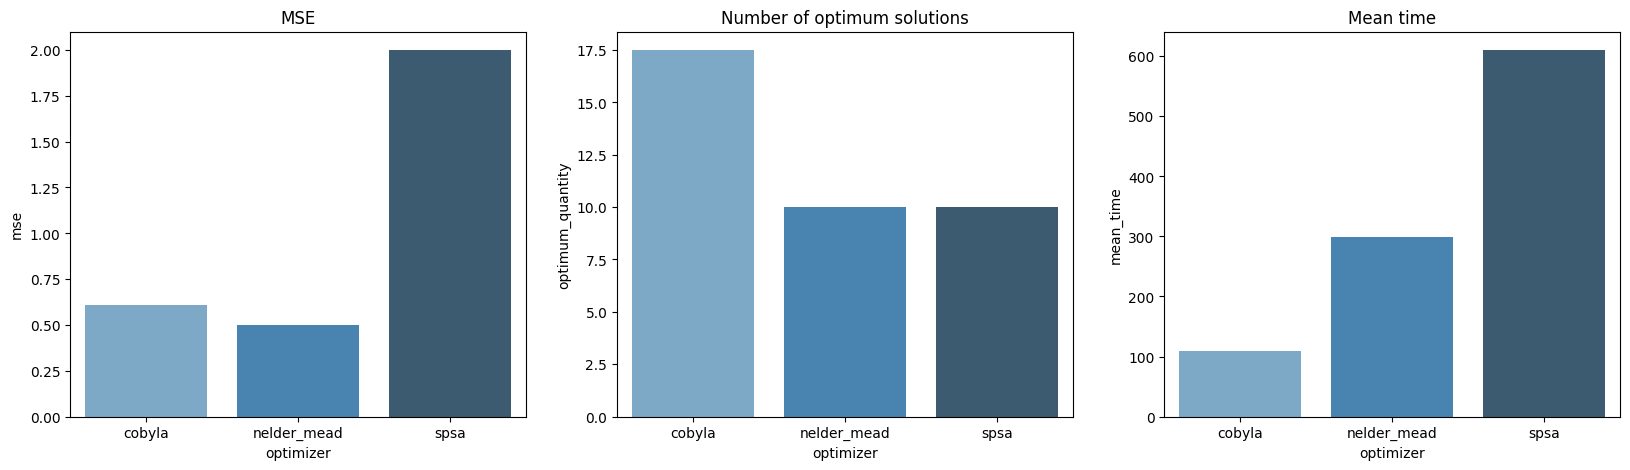

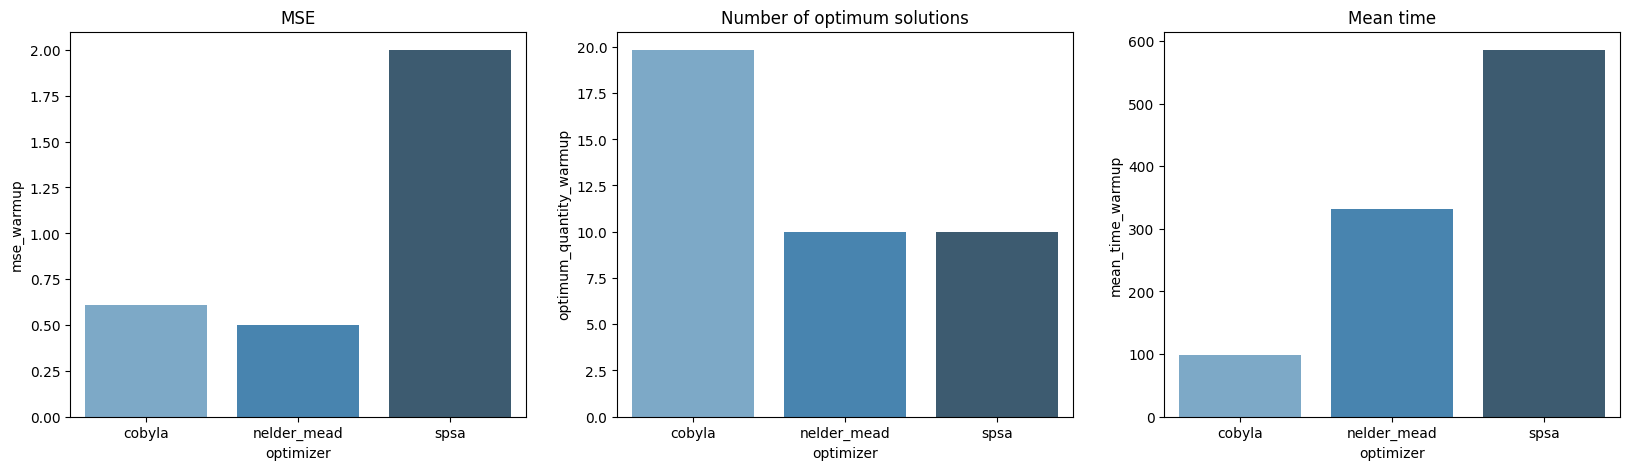

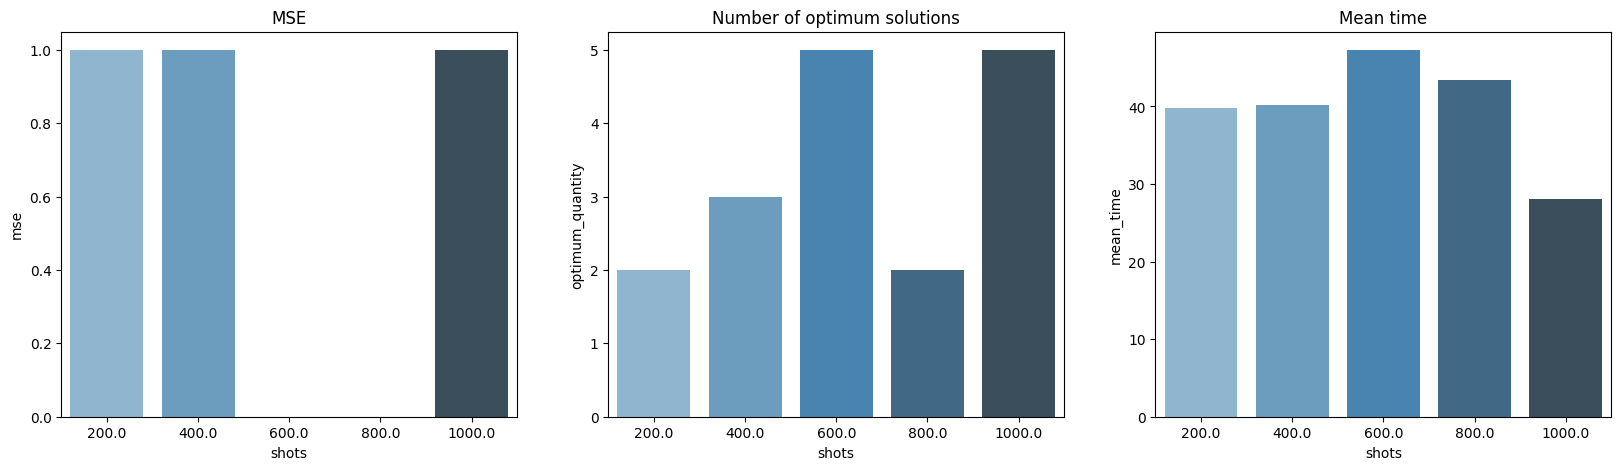

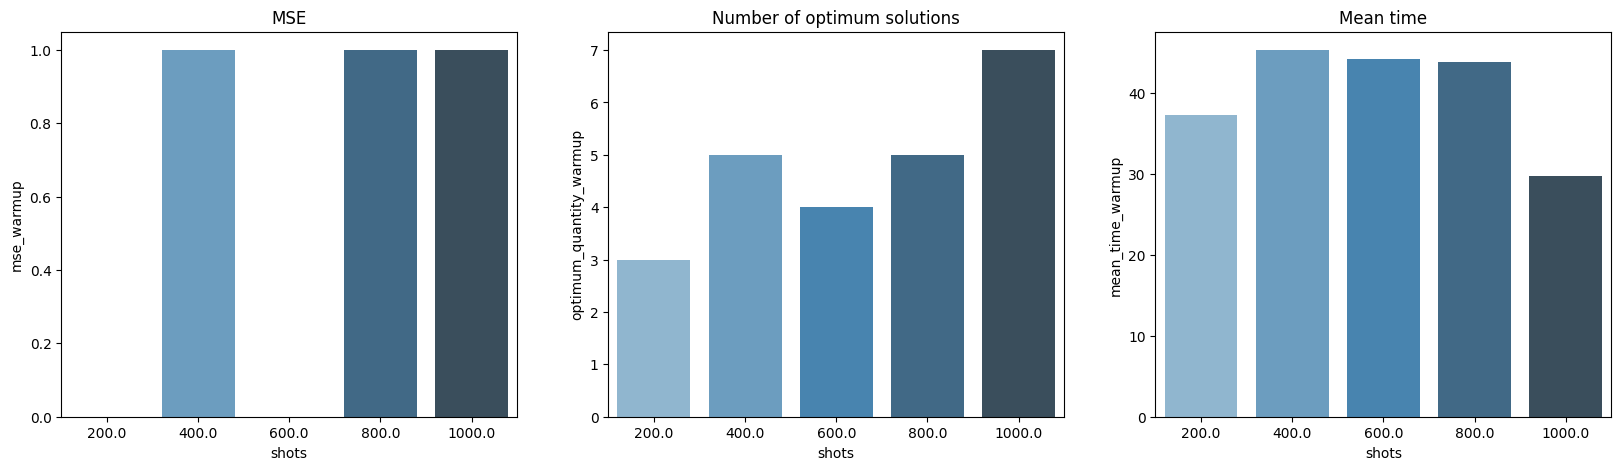

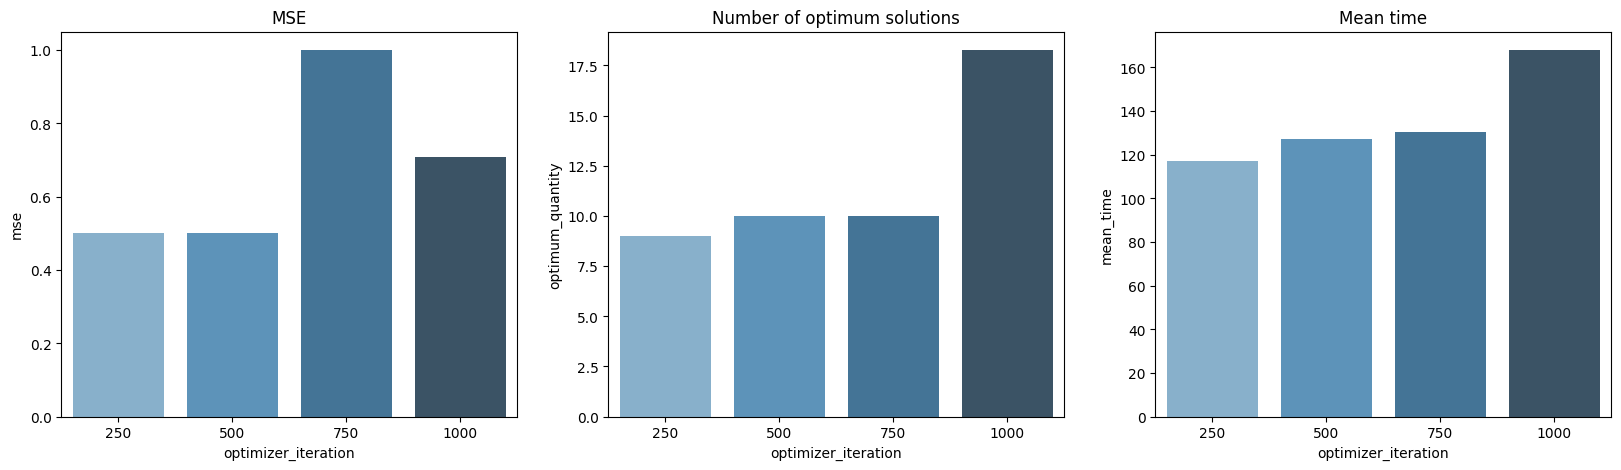

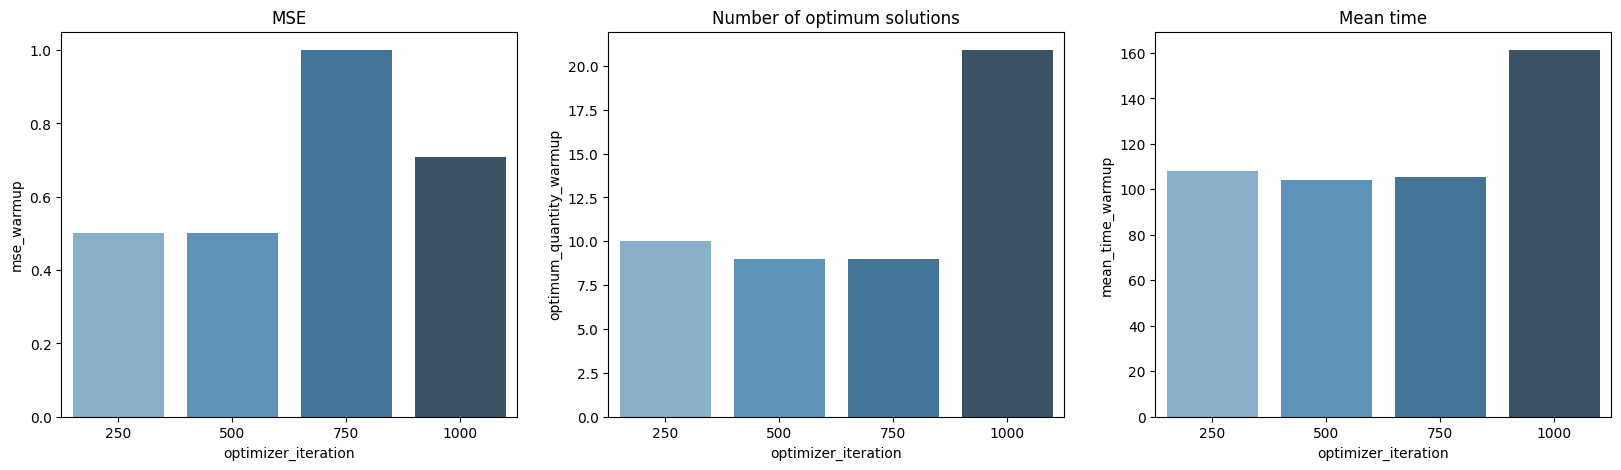

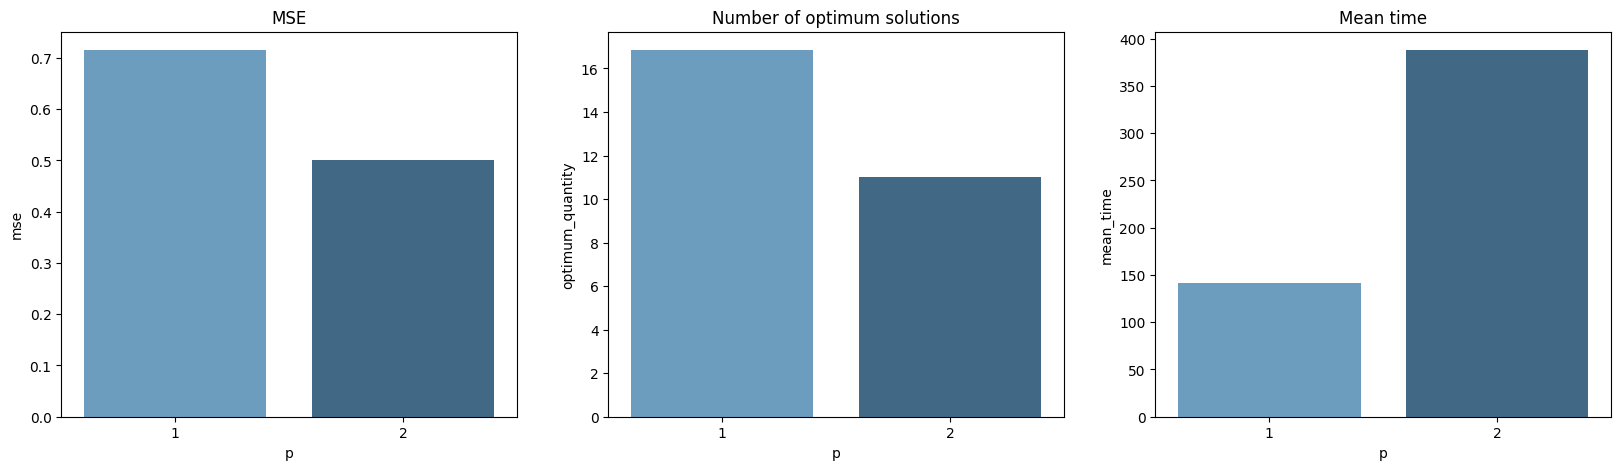

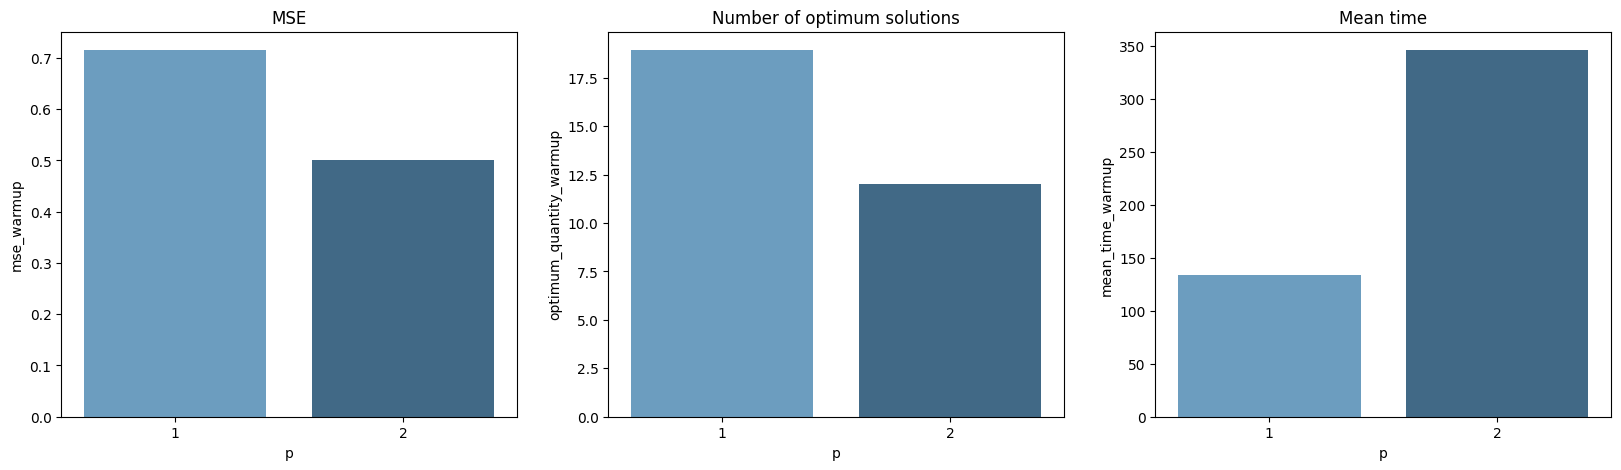

In [85]:
plot_results(pd.DataFrame(results))